# Exploratory data analysis of the dataset

**Exploratory Data Analysis (EDA)** is a crucial initial step in the data analysis process. It involves the exploration, summary, and visualization of key characteristics, patterns, and trends within a dataset. The primary goals of EDA are to understand the structure of the data, identify important variables, detect patterns, anomalies, and relationships, and generate insights that can inform subsequent analysis.

Here are key aspects of Exploratory Data Analysis for a dataset:

* __Descriptive Statistics:__
1. Summary Statistics: Compute measures like mean, median, mode, standard deviation, and quantiles to summarize the central tendency and dispersion of numerical features.
2. Count and Frequency: Determine the count or frequency of unique values in categorical variables.

* __Data Visualization:__
1. Histograms: Visualize the distribution of numerical variables to understand their shape and identify patterns.
2. Box Plots: Identify outliers and assess the spread of the data.
3. Scatter Plots: Explore relationships between pairs of variables, particularly for numerical features.
4. Bar Charts: Visualize the distribution of categorical variables.
5. Correlation Heatmaps: Examine the correlation between numerical features.
  
* __Handling Missing Data:__  
Identify missing values and decide on strategies for handling them, such as imputation or removal.
  
* __Feature Engineering:__  
Identify potential new features or transformations of existing features that may enhance the model's performance.
  
* __Outlier Detection:__  
Identify and understand outliers, whether they are errors or valid data points.    
   
    
* __Target Variable Analysis:__
1. Understand the distribution of the target variable in the case of supervised learning tasks.
2. Explore relationships between predictors and the target variable.

* __Pattern Recognition:__
1. Identify patterns, trends, or seasonality in time-series data.
2. Domain-Specific Exploration:

Conduct domain-specific analysis based on the context of the dataset.

By performing EDA, data analysts and scientists gain a deeper understanding of the dataset, which can guide subsequent steps in the data analysis pipeline, such as feature selection, modeling, and evaluation. EDA helps in making informed decisions, formulating hypotheses, and preparing the data for modeling.

In [1]:
# !pip install --upgrade pip
#!pip install opencv-python
#!pip install seaborn

In [2]:
# Importing necessary libraries for image processing (cv2), numerical operations (numpy), 
# data manipulation (pandas), and data visualization (matplotlib and seaborn).
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
print('Library versions')
print("seaborn=={}".format(sns.__version__))

Library versions
seaborn==0.12.2


In [4]:
# Downloading data
df = pd.read_csv('train_ship_segmentations_v2.csv')

In [5]:
# Print the first few lines
print("Перші кілька рядків даних:")
print(df.head())

Перші кілька рядків даних:
         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
# General information about the data
print("\nЗагальна інформація про дані:")
print(df.info())


Загальна інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB
None


In [7]:
# Opisova statistics
print("\nDescribe statistics:")
print(df.describe())


Describe statistics:
              ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     e6fd0c12e.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2


In [8]:
# Number of unique images
unique_images = df['ImageId'].nunique()
print(f"Number of unique images: {unique_images}")

# Number of ships for each image
ships_per_image = df.groupby('ImageId').count()['EncodedPixels']
print("Number of ships for each image:")
print(ships_per_image)

Number of unique images: 192556
Number of ships for each image:
ImageId
00003e153.jpg    0
0001124c7.jpg    0
000155de5.jpg    1
000194a2d.jpg    5
0001b1832.jpg    0
                ..
fffedbb6b.jpg    0
ffff2aa57.jpg    0
ffff6e525.jpg    0
ffffc50b4.jpg    0
ffffe97f3.jpg    0
Name: EncodedPixels, Length: 192556, dtype: int64


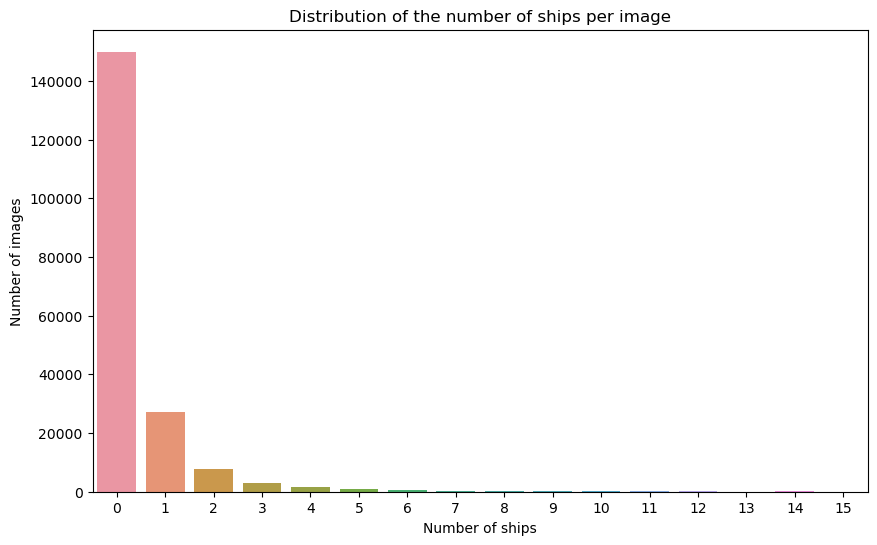

In [9]:
# Graph of the distribution of the number of ships per image
plt.figure(figsize=(10, 6))
sns.countplot(x=ships_per_image)
plt.title('Distribution of the number of ships per image')
plt.xlabel('Number of ships')
plt.ylabel('Number of images')
plt.show()

Descriptive statistics of ship mask sizes:
count    231723.000000
mean         37.711915
std          84.069723
min           1.000000
25%           1.000000
50%           1.000000
75%          32.000000
max         888.000000
Name: MaskLength, dtype: float64


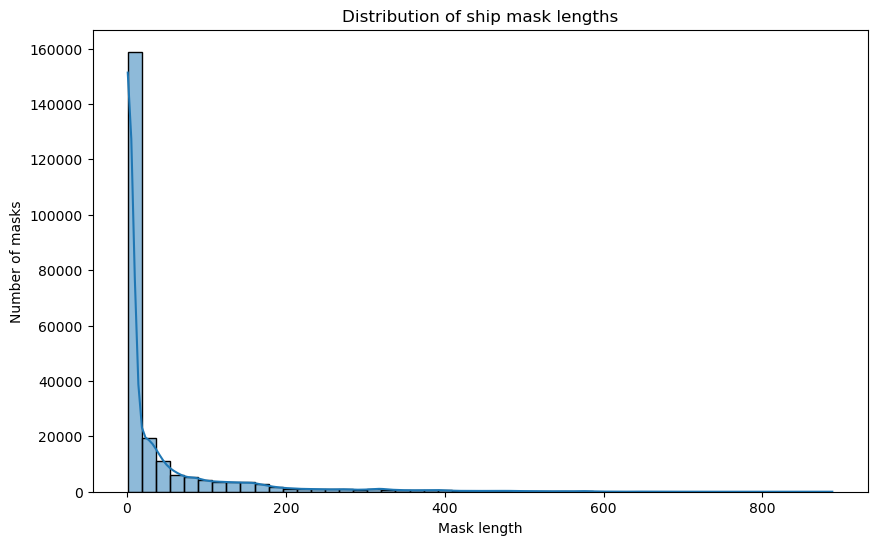

In [10]:
# General information about the length of EncodedPixels
df['MaskLength'] = df['EncodedPixels'].apply(lambda x: len(str(x).split()))
print("Descriptive statistics of ship mask sizes:")
print(df['MaskLength'].describe())

# Graph of the distribution of mask lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['MaskLength'], bins=50, kde=True)
plt.title('Distribution of ship mask lengths')
plt.xlabel('Mask length')
plt.ylabel('Number of masks')
plt.show()

In [11]:
# Checking for missing values in other columns
missing_values = df.isnull().sum()
print("Missing values in other columns:")
print(missing_values[missing_values > 0])

Missing values in other columns:
EncodedPixels    150000
dtype: int64


Visualize images and masks.

In [12]:
def rle_decode(mask_rle, shape):
    # Create an empty mask
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # If EncodedPixels is not empty
    if pd.notna(mask_rle):
        # Split the EncodedPixels string
        s = mask_rle.split()

        # Get starts, lengths, and ends
        starts, lengths = [int(s[i]) - 1 for i in range(0, len(s), 2)], [int(s[i]) for i in range(1, len(s), 2)]
        ends = [start + length for start, length in zip(starts, lengths)]

        # Set pixels to 1 in the mask
        for start, end in zip(starts, ends):
            img[start:end] = 1

    # Reshape the mask to the desired shape
    return img.reshape(shape[:2], order='F')



def visualize_masks(image_id):
    image_path = f"train_v2/{image_id}"
    img = cv2.imread(image_path)
    
    # Getting EncodedPixels for a given ImageId
    masks = df[df['ImageId'] == image_id]['EncodedPixels'].tolist()

    # Decoding masks
    decoded_masks = [rle_decode(mask, img.shape) for mask in masks]
    
    # Combining all masks
    full_mask = np.zeros_like(img[:, :, 0])

    for mask in decoded_masks:
        full_mask += mask

    # Display original image and masks
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(full_mask, cmap='gray')
    plt.title('Combined Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(full_mask, alpha=0.3, cmap='jet')  # Overlay the mask on the image
    plt.title('Image with Overlay')

    plt.show()

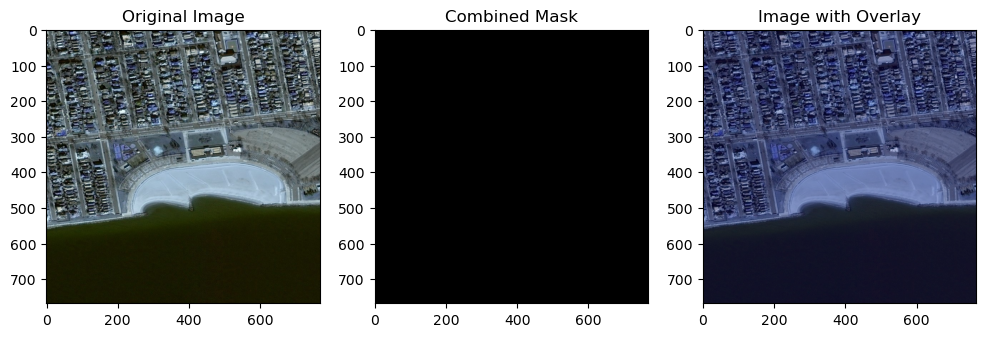

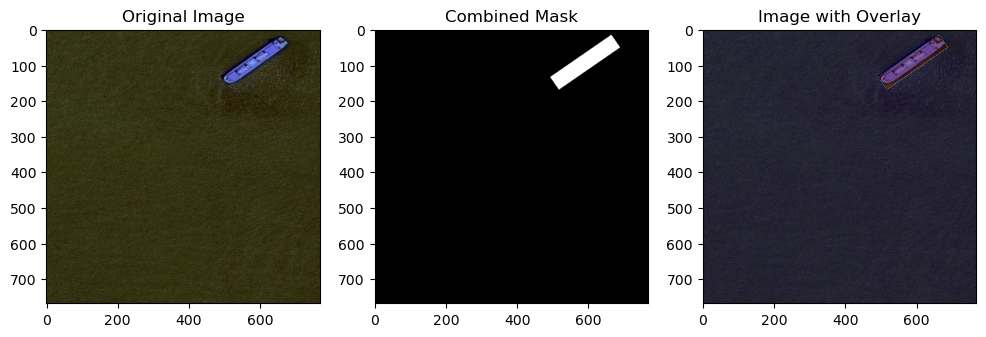

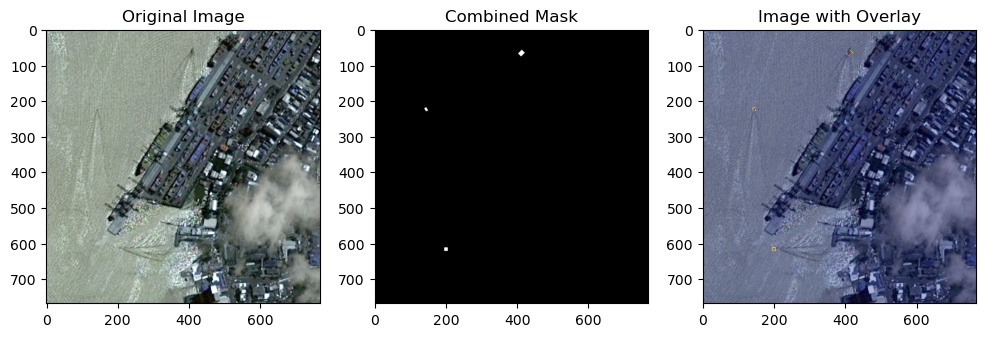

In [13]:
# Provide a list of image names you want to visualize
selected_image_names = ['00a52cd2a.jpg', '000c34352.jpg', '00c996565.jpg']

# Use the list to filter the DataFrame
sample_images = df[df['ImageId'].isin(selected_image_names)]['ImageId'].unique().tolist()

# Take the first three images (in case there are more)
sample_images = sample_images[:3]

for image_id in sample_images:
    visualize_masks(image_id)